In [48]:
import datetime
import os
import random
import readline
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import netCDF4
import numpy
import pandas
import scipy
import seaborn
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import colors, font_manager, pyplot
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from scipy import fft, linalg, stats
from scipy.stats import poisson, ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg

In [49]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.4.2/'

In [50]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [51]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_hPa_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_hPa_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time = []
    Birth_Time = []
    Begin_Time = []
    Compl_Time = []
    Death_Time = []
    Peak_Time = []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [52]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [53]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
Lat_Bins = Create_Bins(10,60,5)
Lon_Bins = Create_Bins(-100,20,5)

In [54]:
Num_Years = numpy.array([90,93,93])

In [55]:
Control_Data_All, Control_ET_All, Control_Codes = Files_Open("Control", Diri)
RCP45_Data_All, RCP45_ET_All, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data_All, RCP85_ET_All, RCP85_Codes = Files_Open("RCP85", Diri)

In [56]:
# Filter For Just Storms That Completed ET Transition
def ET_Filter(Data_DF_Orig, ET_DF_Orig):
    ET_DF = ET_DF_Orig[ET_DF_Orig["Trans Type"] > 0].reset_index()
    ET_DF = ET_DF.drop("index", axis=1)
    Code_List = ET_DF["Code"]
    Filtered_DF = Data_DF_Orig[Data_DF_Orig["Code"].isin(Code_List)].reset_index()
    Filtered_DF = Filtered_DF.drop("index", axis=1)
    return (Filtered_DF, ET_DF)

In [57]:
# Apply Function
Control_Data, Control_ET = ET_Filter(Control_Data_All, Control_ET_All)
RCP45_Data, RCP45_ET = ET_Filter(RCP45_Data_All, RCP45_ET_All)
RCP85_Data, RCP85_ET = ET_Filter(RCP85_Data_All, RCP85_ET_All)

In [58]:
# Create Function to Plot ET Begin and Complete Locations
def Plot_ET_Locs(ET_DF, Model, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,13))
#
# Plot ET Begin Locations
    Axis = Fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
    Begin_Lons = ET_DF["ET Begin Lon"]
    Begin_Lats = ET_DF["ET Begin Lat"]
    for k in range(len(Begin_Lats)):
        pyplot.scatter(Begin_Lons[k], Begin_Lats[k], marker='s', linewidths=1.8, \
        facecolors='none', edgecolors='black', s=48)
    Plot_Map_Formatting(Axis)
    Title = Model + " Extratropical Transition Initiation Locations"
    Axis.set_title(Title, fontsize=24)
#
# Plot ET Complete Data
    Axis = Fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
    Compl_Lons = ET_DF["ET Complete Lon"]
    Compl_Lats = ET_DF["ET Complete Lat"]
    for k in range(len(Compl_Lats)):
        pyplot.scatter(Compl_Lons[k], Compl_Lats[k], marker='^', linewidths=1.8, \
        facecolors='none', edgecolors='black', s=48)
    Plot_Map_Formatting(Axis)
    Title = Model + " Extratropical Transition Completion Locations"
    Axis.set_title(Title, fontsize=24)
#
# Save Fig
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

In [59]:
# Create Function to Plot ET Begin and Complete Locations
def Plot_Birth_Locs(ET_DF, Model, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,13))
#
# Plot ET Begin Locations
    Axis = Fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
    Begin_Lons = ET_DF["Genesis Lon"]
    Begin_Lats = ET_DF["Genesis Lat"]
    for k in range(len(Begin_Lats)):
        pyplot.scatter(Begin_Lons[k], Begin_Lats[k], marker='o', linewidths=1.8, \
        facecolors='none', edgecolors='black', s=48)
    Plot_Map_Formatting(Axis)
    Title = Model + " Genesis Locations"
    Axis.set_title(Title, fontsize=24)
#
# Plot ET Complete Data
    Axis = Fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
    Compl_Lons = ET_DF["Dissipate Lon"]
    Compl_Lats = ET_DF["Dissipate Lat"]
    for k in range(len(Compl_Lats)):
        pyplot.scatter(Compl_Lons[k], Compl_Lats[k], marker='v', linewidths=1.8, \
        facecolors='none', edgecolors='black', s=48)
    Plot_Map_Formatting(Axis)
    Title = Model + " Dissipation Locations"
    Axis.set_title(Title, fontsize=24)
#
# Save Fig
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

In [60]:
def Plot_Map_Formatting(Axis):
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    x_Min = -100
    x_Max = 20
    y_Min = 10
    y_Max = 60
    x_Axis = Create_Bins(x_Min, x_Max, 10)
    y_Axis = Create_Bins(y_Min, y_Max, 10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

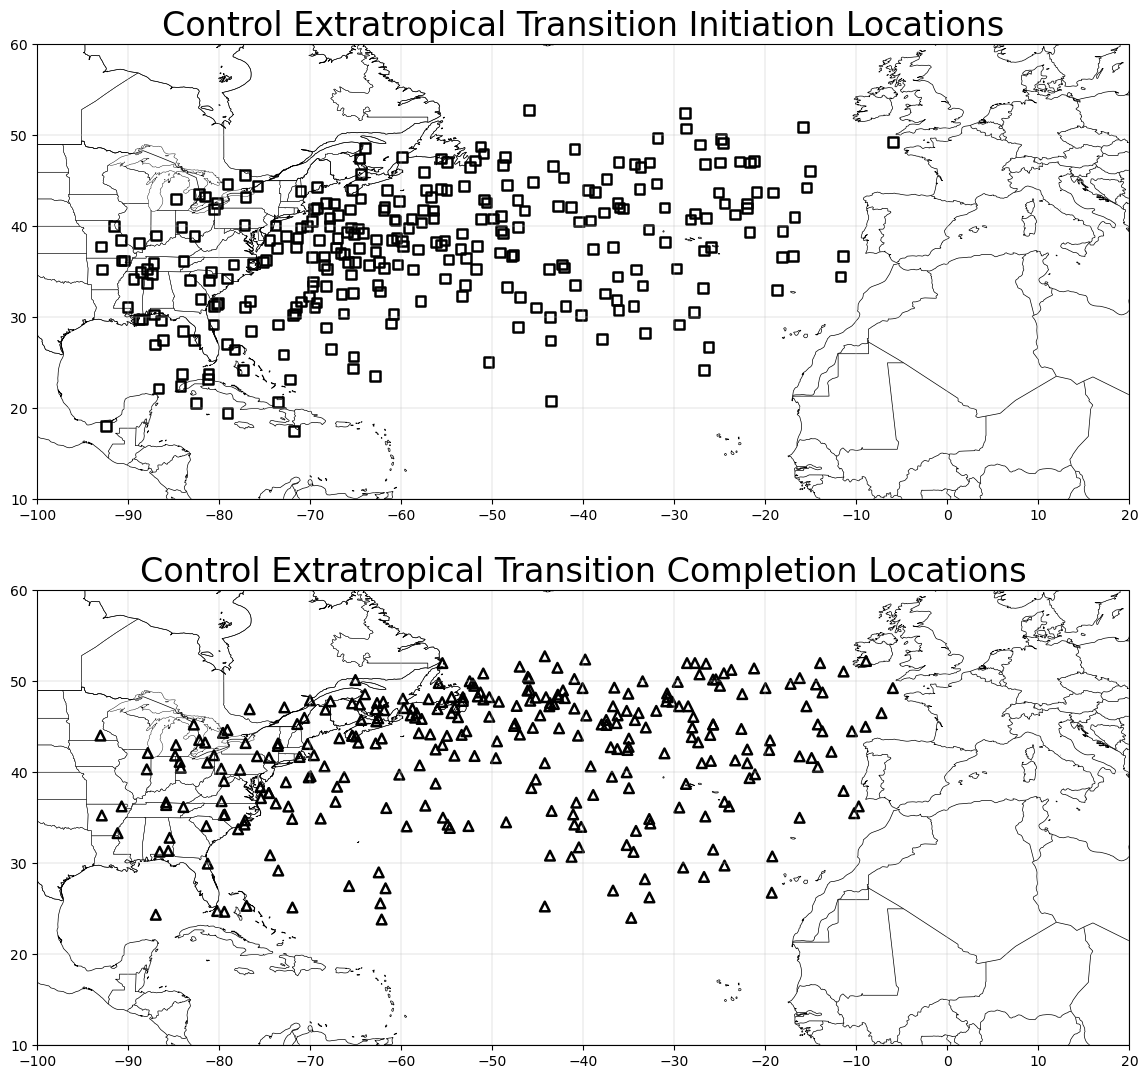

In [61]:
Plot_ET_Locs(Control_ET, "Control", True, 'Control_ET_Loc')

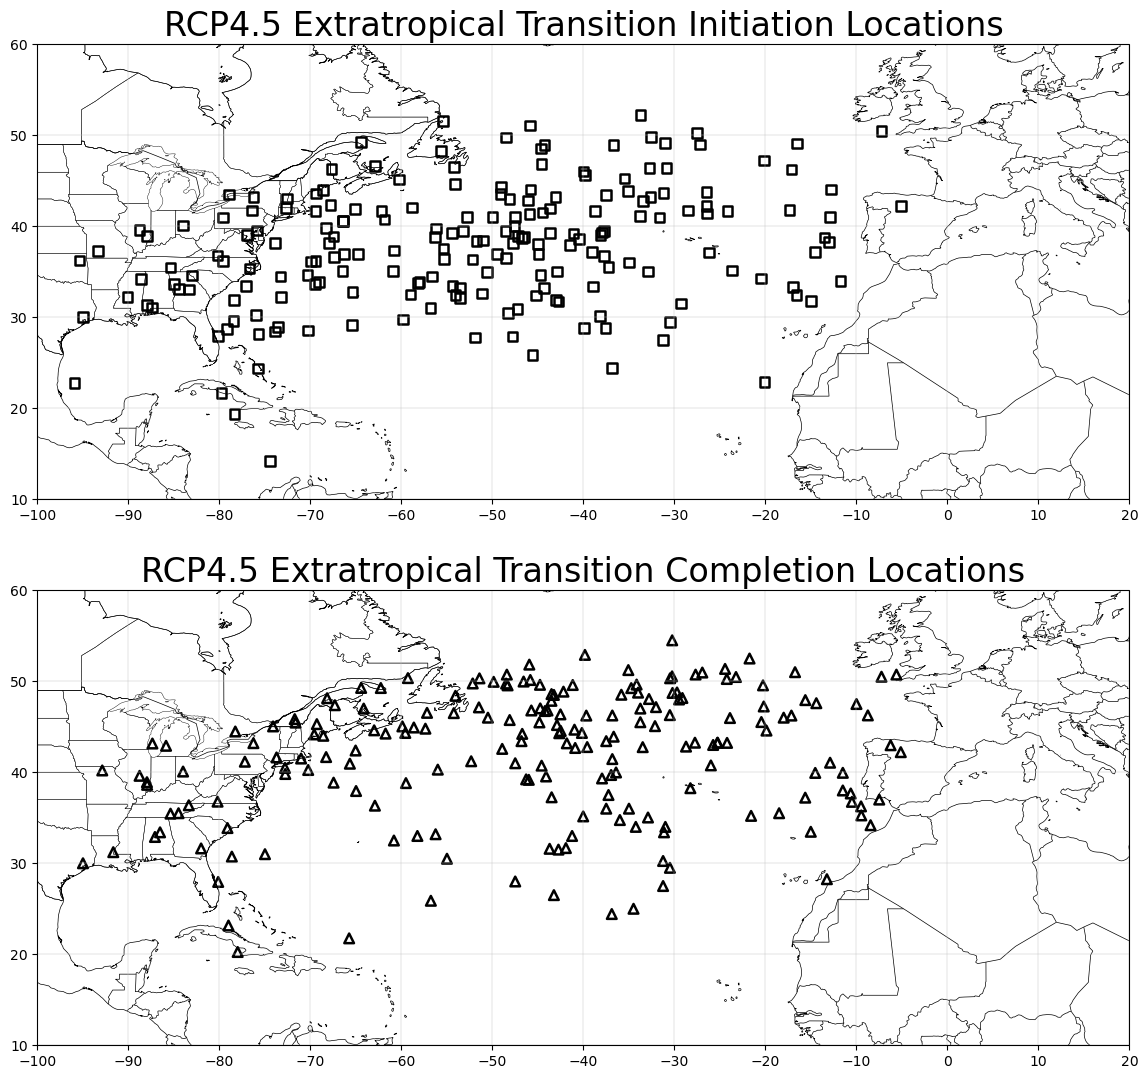

In [62]:
Plot_ET_Locs(RCP45_ET, "RCP4.5", True, 'RCP45_ET_Loc')

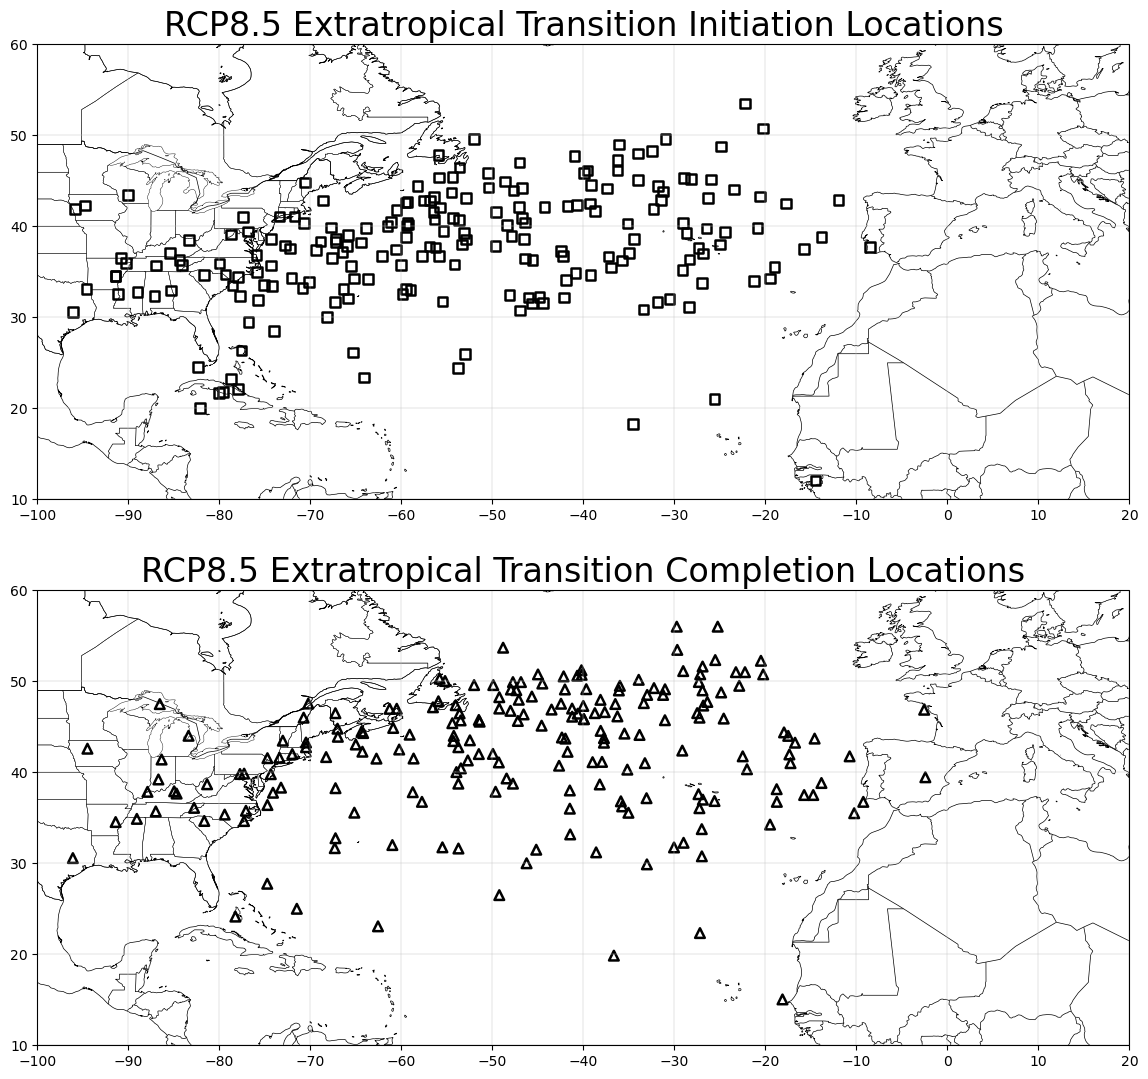

In [63]:
Plot_ET_Locs(RCP85_ET, "RCP8.5", True, 'RCP85_ET_Loc')

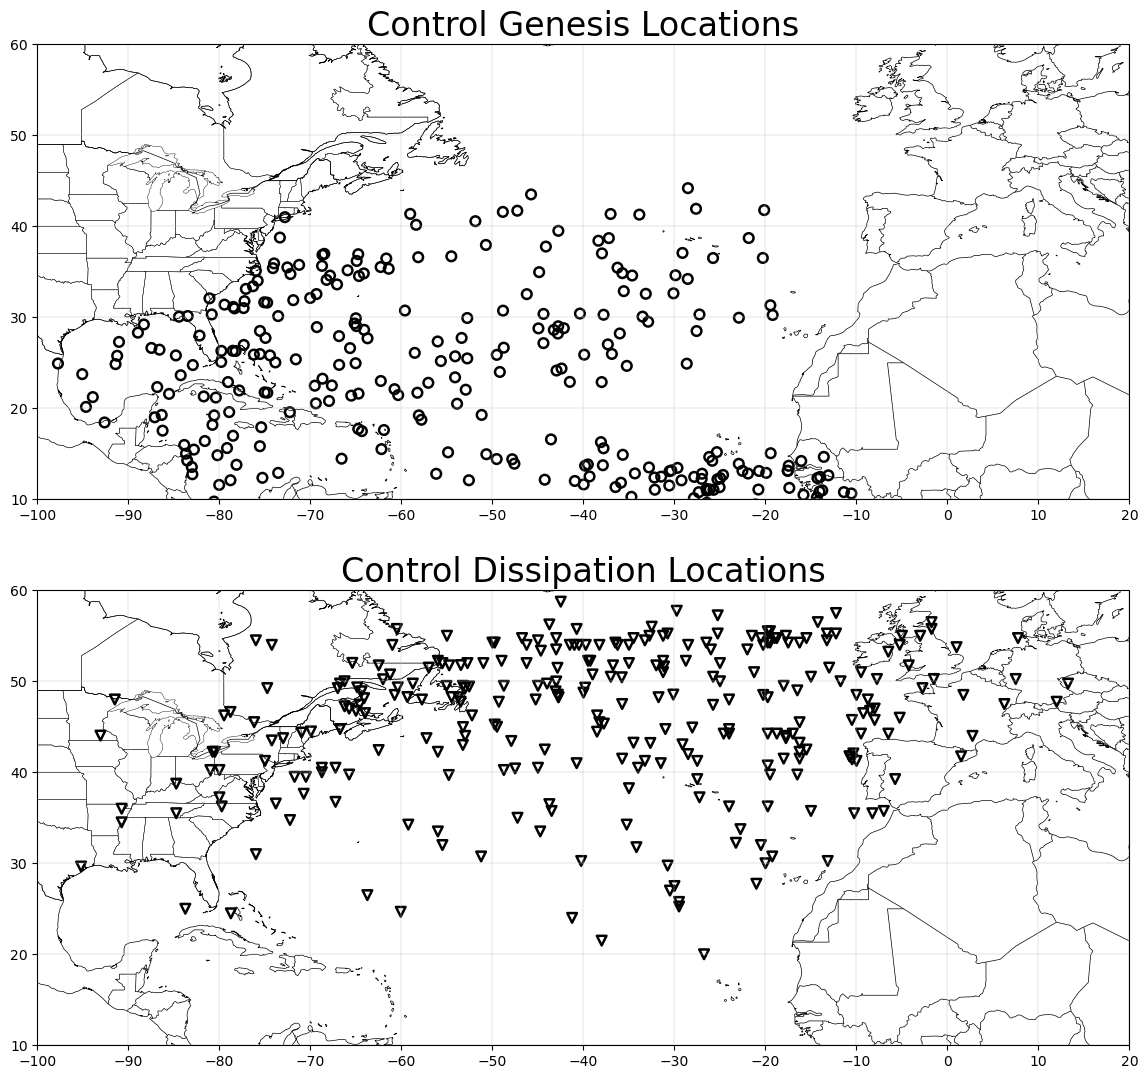

In [64]:
Plot_Birth_Locs(Control_ET, "Control", False, 'Control_Birth_Loc')

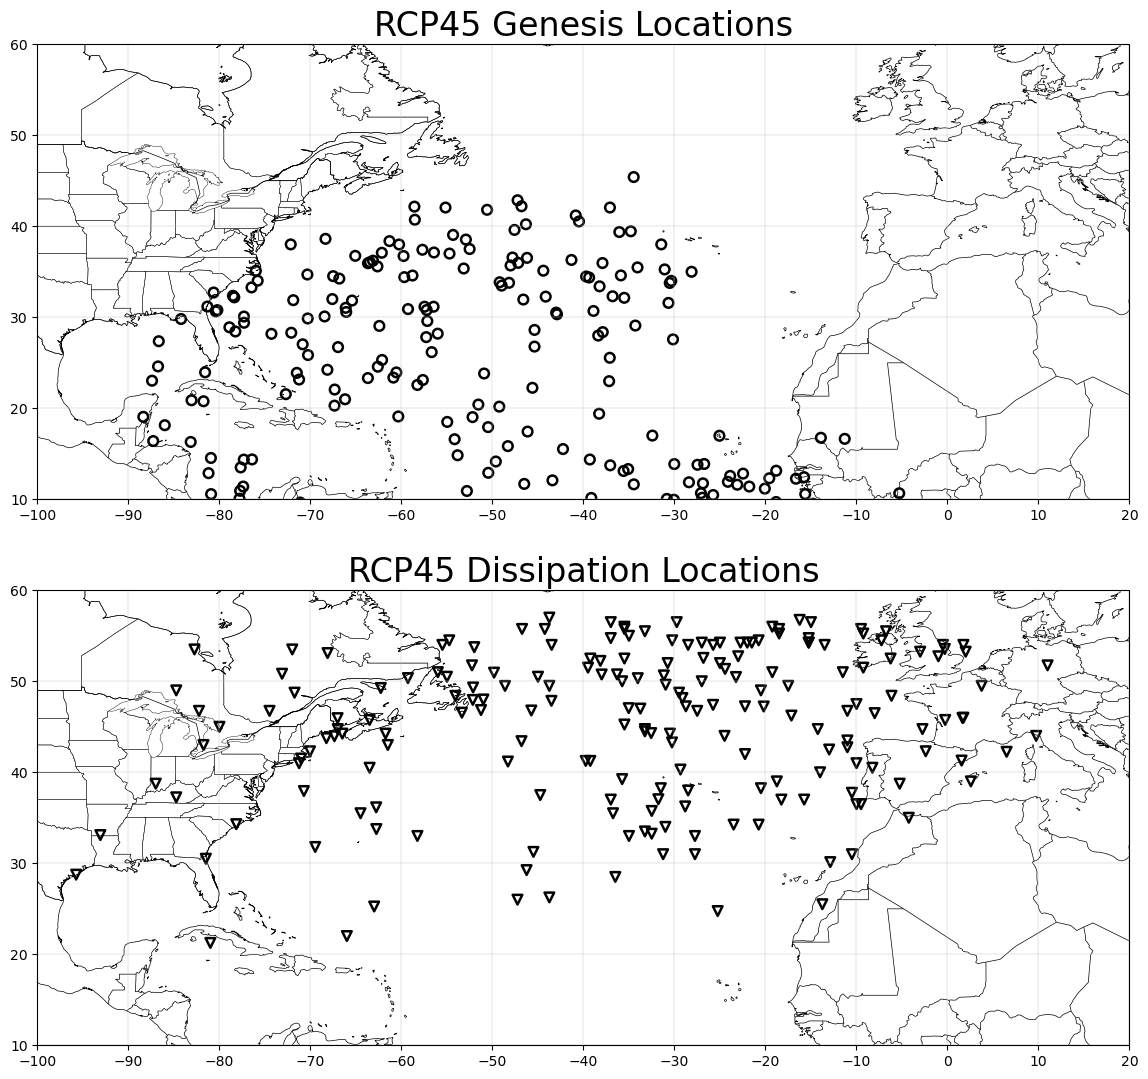

In [65]:
Plot_Birth_Locs(RCP45_ET, "RCP45", False, 'RCP45_Birth_Loc')

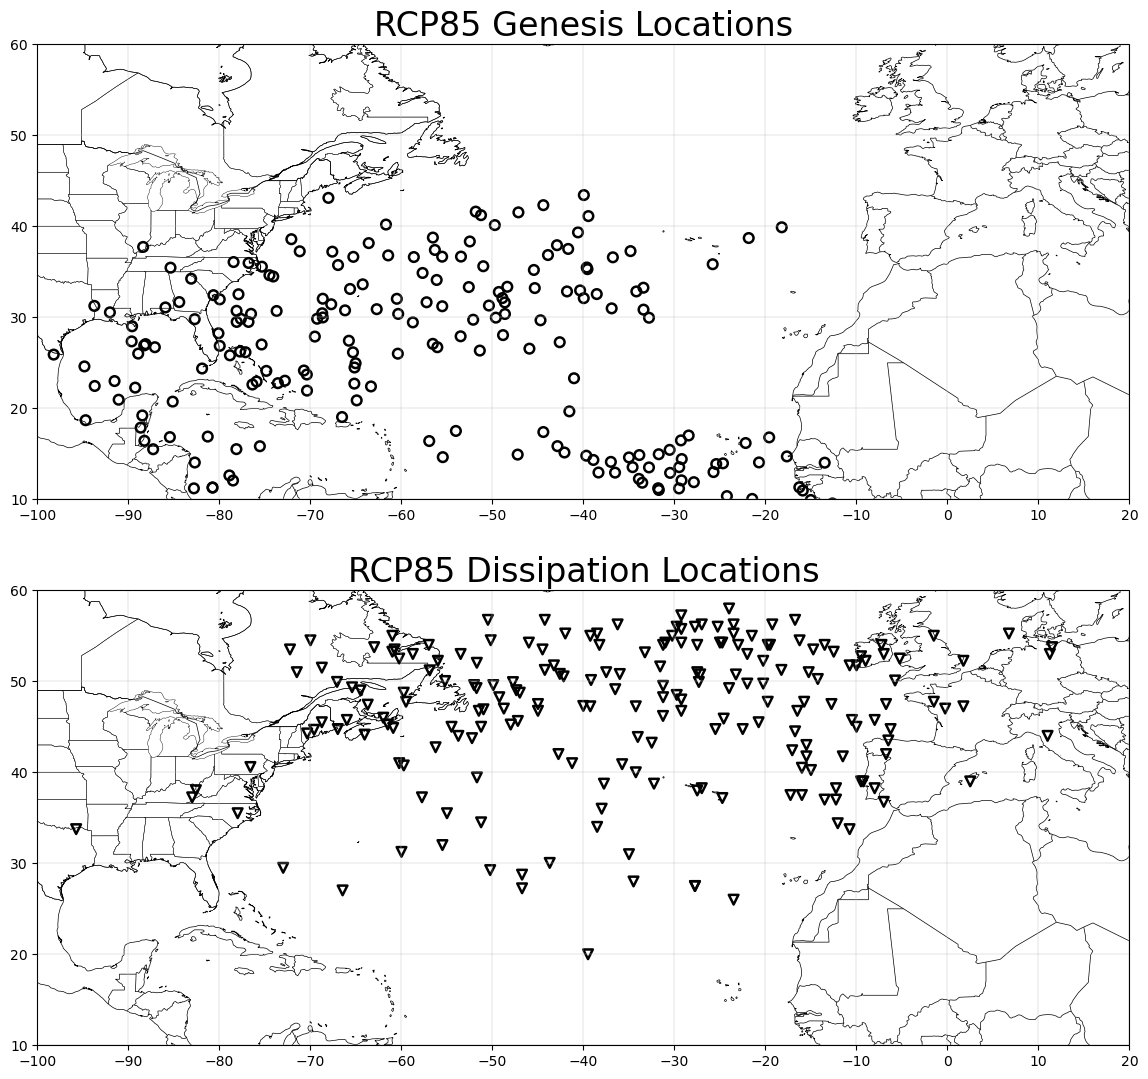

In [66]:
Plot_Birth_Locs(RCP85_ET, "RCP85", False, 'RCP85_Birth_Loc')

In [67]:
# Create Function to Calculate ET Locations Spatial Distribution
def ET_Locs_Distr(ET_DF, Lat_Bins, Lon_Bins, Model, Rela):
# Count ET Locations Distribution
    Length = len(ET_DF)
    Begin_Count = ET_Loc_Count(ET_DF, True, Length, Lat_Bins, Lon_Bins, 0, 0)
    Compl_Count = ET_Loc_Count(ET_DF, False, Length, Lat_Bins, Lon_Bins, 0, 0)
#
# Calculate ET Locations Density
    if Rela == True:
        Begin_Density = Begin_Count / Length * 100
        Compl_Density = Compl_Count / Length * 100
        return (Begin_Density, Compl_Density)
#
# Calculate ET Locations Annual
    else:
        if Model == "Control":
            Num_Year = 90
        else:
            Num_Year = 93
        Begin_Annual = Begin_Count / Num_Year * 100
        Compl_Annual = Compl_Count / Num_Year * 100
        return (Begin_Annual, Compl_Annual)

In [68]:
# Create Function to Calculate ET Locations Spatial Distribution
def ET_Locs_Distr_Smooth(ET_DF, Lat_Bins, Lon_Bins, Model, Rela):
# Count ET Locations Distribution
    Length = len(ET_DF)
    Params_Lat = Create_Bins(0,5,1.25)
    Params_Lon = Create_Bins(0,10,2.5)
    Begin_Count_Sum = numpy.zeros((len(Lat_Bins)-1, len(Lon_Bins)-1))
    Compl_Count_Sum = numpy.zeros((len(Lat_Bins)-1, len(Lon_Bins)-1))
    for n in range(len(Params_Lat)):
        Begin_Count = ET_Loc_Count(ET_DF, True, Length, Lat_Bins, Lon_Bins, Params_Lat[n], Params_Lon[n])
        Compl_Count = ET_Loc_Count(ET_DF, False, Length, Lat_Bins, Lon_Bins, Params_Lat[n], Params_Lon[n])
        Begin_Count_Sum += Begin_Count
        Compl_Count_Sum += Compl_Count
    Begin_Count_Mean = Begin_Count_Sum / len(Params_Lat)
    Compl_Count_Mean = Compl_Count_Sum / len(Params_Lat)
#
# Calculate ET Locations Density
    if Rela == True:
        Begin_Density = Begin_Count_Mean / Length * 100
        Compl_Density = Compl_Count_Mean / Length * 100
        return (Begin_Density, Compl_Density)
#
# Calculate ET Locations Annual
    else:
        if Model == "Control":
            Num_Year = 90
        else:
            Num_Year = 93
        Begin_Annual = Begin_Count_Mean / Num_Year * 100
        Compl_Annual = Compl_Count_Mean / Num_Year * 100
        return (Begin_Annual, Compl_Annual)

In [69]:
# Count ET Locations Distribution
def ET_Loc_Count(ET_DF, Begin, Length, Lat_Bins, Lon_Bins, Param_Lat, Param_Lon):
    Lat_Lon_Count = numpy.zeros((len(Lat_Bins)-1, len(Lon_Bins)-1))
    Lat_Lon_Length = 0
#
# Count Lat Lon Distribution in Each Gridbox
    if Begin == True:
        Lats = ET_DF["ET Begin Lat"]
        Lons = ET_DF["ET Begin Lon"]
    else:
        Lats = ET_DF["ET Complete Lat"]
        Lons = ET_DF["ET Complete Lon"]
    for i in range(len(Lats)):
        for j in range(len(Lat_Bins)-1):
            if Lats[i] >= Lat_Bins[j]-Param_Lat and Lats[i] <= Lat_Bins[j+1]+Param_Lat:
                for k in range(len(Lon_Bins)-1):
                    if Lons[i] >= Lon_Bins[k]-Param_Lon and Lons[i] <= Lon_Bins[k+1]+Param_Lon:
                        Lat_Lon_Count[j][k] += 1
                        Lat_Lon_Length += 1
    Lat_Lon_Final = Lat_Lon_Count / Lat_Lon_Length * Length
    return (Lat_Lon_Final)

In [70]:
# Create Function For Spatial Distribution Count Colours
Spatial_Colours = ['lightskyblue', 'deepskyblue', 'limegreen', 'greenyellow', 'yellow', 'orange', 'red']
Spatial_Rela_Bounds = numpy.array([0,0.5,1,1.5,2,2.5,3])
Spatial_Annual_Bounds = numpy.array([0,1,2,3,4,5,6])
#
# Create Function For Colours
def Spatial_Colour(Density, Distr_Bounds, Distr_Colours):
    for k in range(len(Distr_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k != len(Distr_Colours)-1:
                if Density <= Distr_Bounds[k+1] and Density > Distr_Bounds[k]:
                    Colour = Distr_Colours[k]
            else:
                if Density > Distr_Bounds[k]:
                    Colour = Distr_Colours[k]
    return (Colour)

In [71]:
# Create Function to Plot ET Begin and Complete Locations
def ET_Distr_Plot(ET_DF, Model, Rela, Smooth, Savefig):
# Use Function to Calculate Distributions
    Lat_Bins = Create_Bins(10,60,5)
    Lon_Bins = Create_Bins(-100,20,5)
    if Smooth == False:
        Spatial_Begin, Spatial_Compl = ET_Locs_Distr(ET_DF, Lat_Bins, Lon_Bins, Model, Rela)
    else:
        Spatial_Begin, Spatial_Compl = ET_Locs_Distr_Smooth(ET_DF, Lat_Bins, Lon_Bins, Model, Rela)
#
# Define Colours and Bounds
    if Rela == True:
        Bounds = Spatial_Rela_Bounds
        Colours = Spatial_Colours
    else:
        Bounds = Spatial_Annual_Bounds
        Colours = Spatial_Colours
    Fig = pyplot.figure(figsize=(16,16))
#
# Plot ET Begin Distrbution
    Axis = Fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
    for j in range(len(Spatial_Begin)):
        for k in range(len(Spatial_Begin[0])):
            Colour = Spatial_Colour(Spatial_Begin[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    if Rela == True:
        Type = "Relative"
    else:
        Type = "Annual"
    Title = Model + " -- Spatial Distribution of ET Initiation (" + Type + ")"
    Axis.set_title(Title, fontsize=24)
#
# Colour Bar
    if Rela == True:
        Cbar_Label = 'Frequency (Per 100 Data Points)'
    else:
        Cbar_Label = 'Frequency (Per 100 Years)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Frequency of Locations", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([0.11, -0.12, 0.78, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, ticks=Bounds, \
    label=Cbar_Label)
#
#
# Plot ET Complete Distribution
    Axis = Fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
    for j in range(len(Spatial_Compl)):
        for k in range(len(Spatial_Compl[0])):
            Colour = Spatial_Colour(Spatial_Compl[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    Title = Model + " -- Spatial Distribution of ET Completion (" + Type + ")"
    Axis.set_title(Title, fontsize=24)
#
# Save Fig
    if Savefig == True:
        Figname = str(Model + '_ET_Spatial_Distr.png')
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

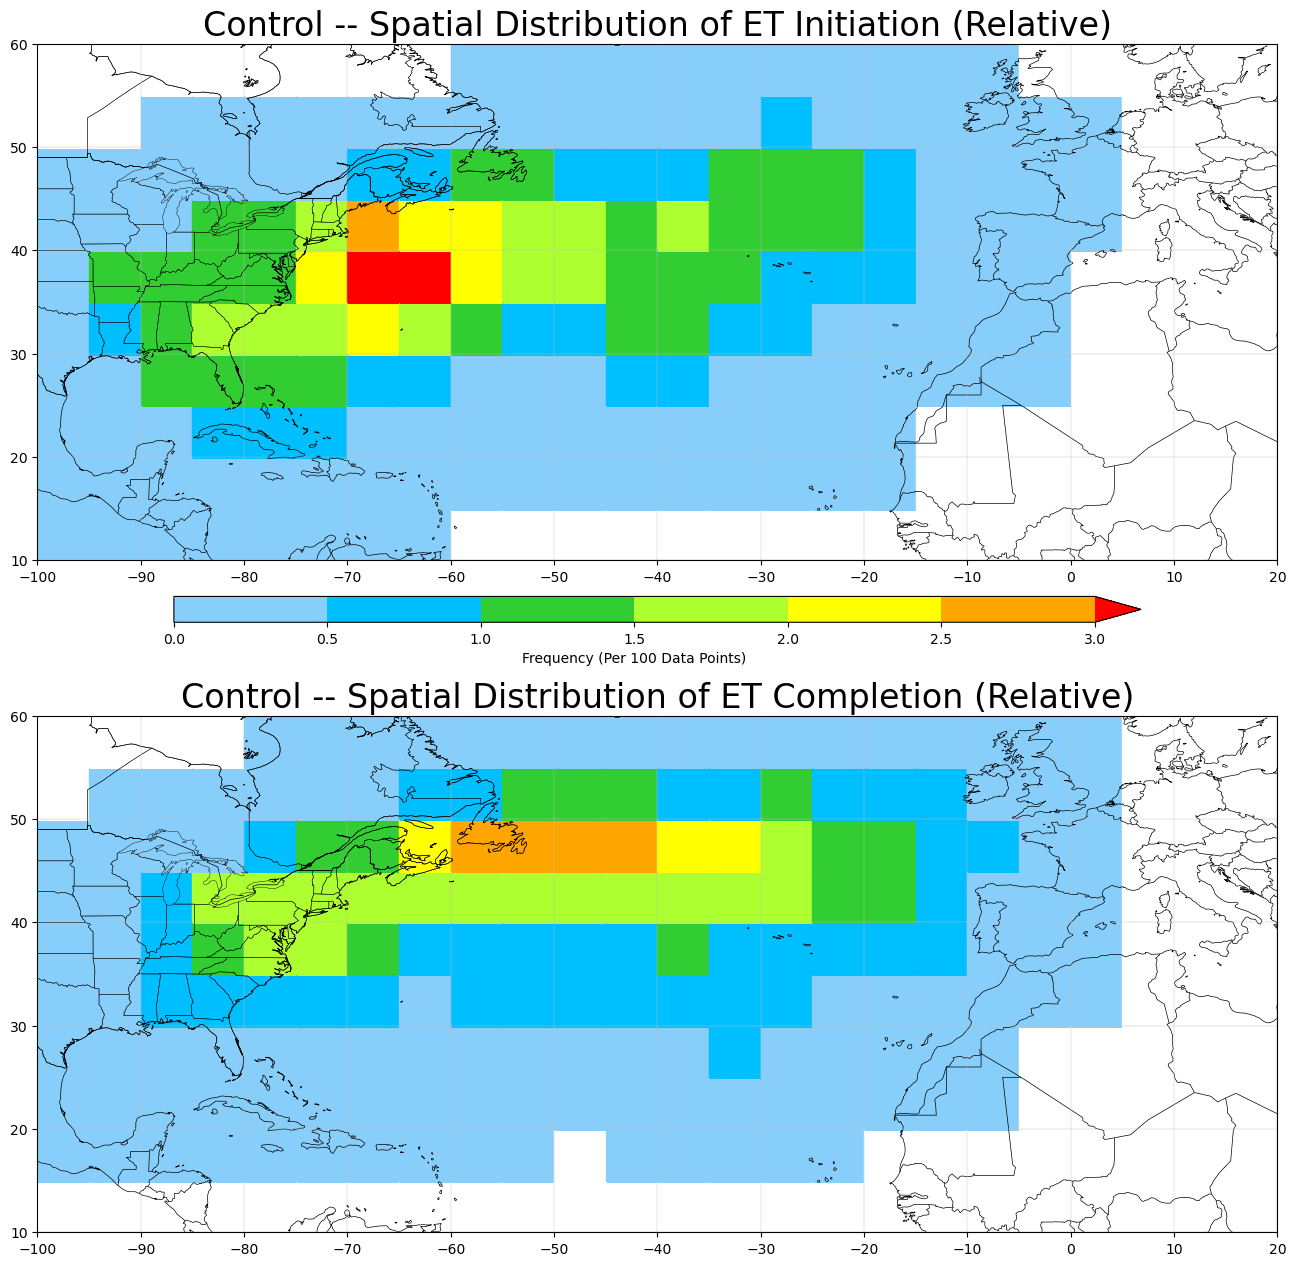

In [72]:
ET_Distr_Plot(Control_ET, "Control", True, True, True)

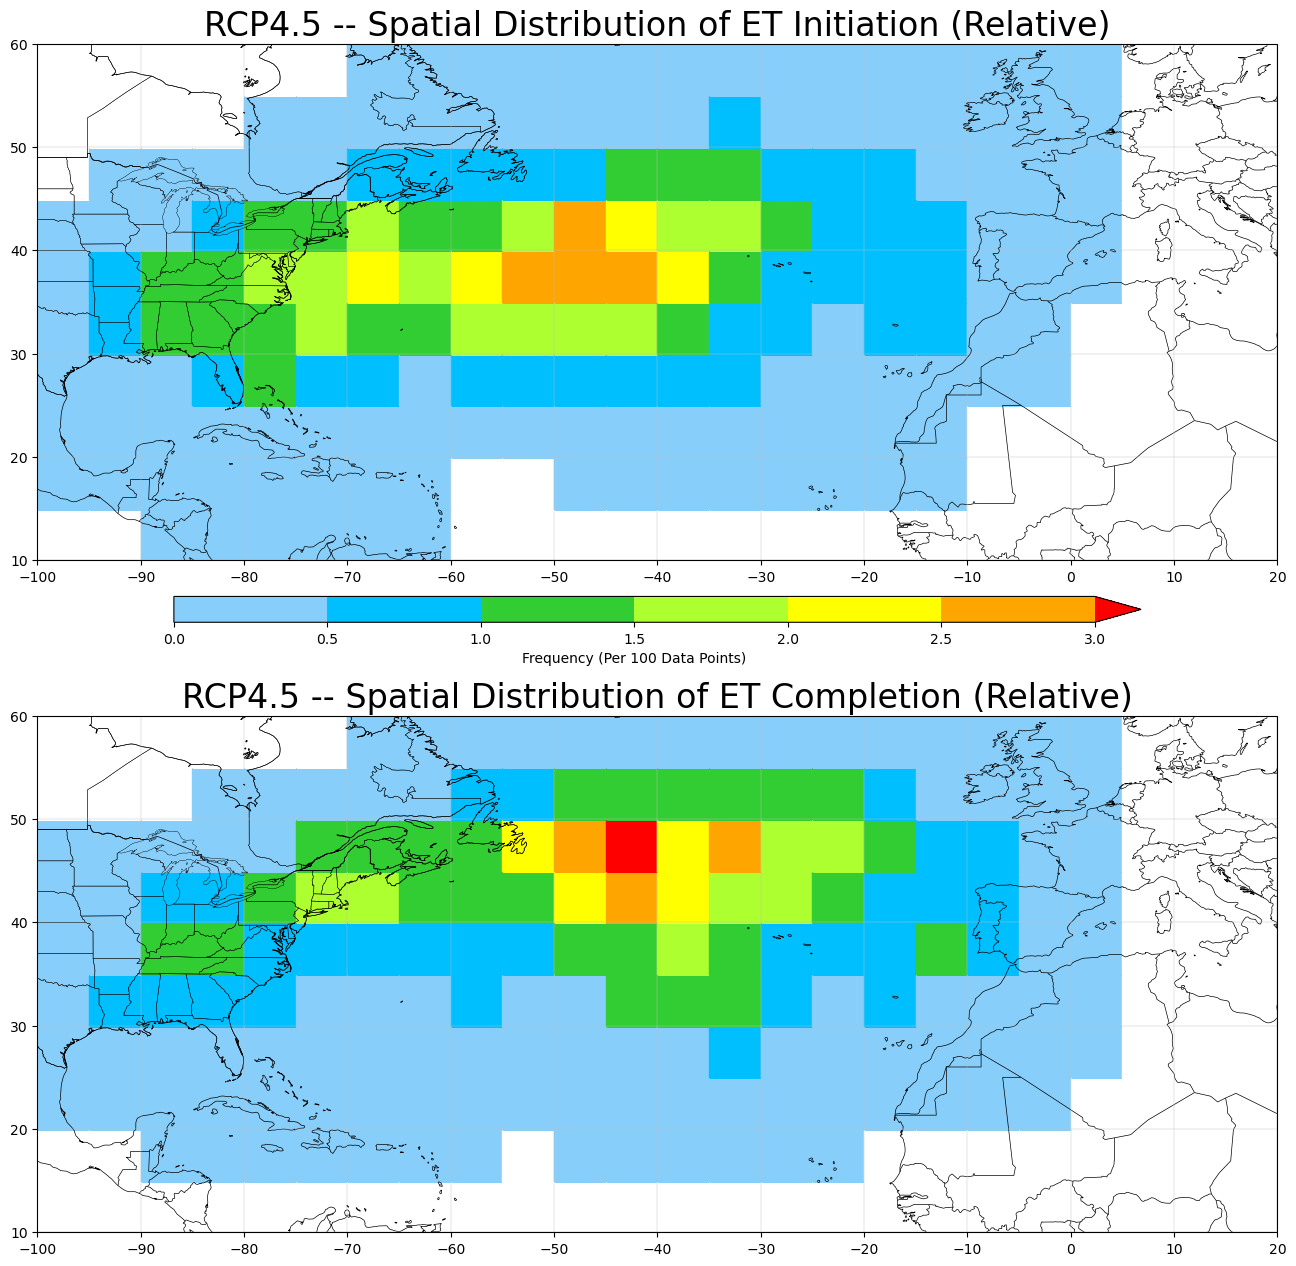

In [73]:
ET_Distr_Plot(RCP45_ET, "RCP4.5", True, True, True)

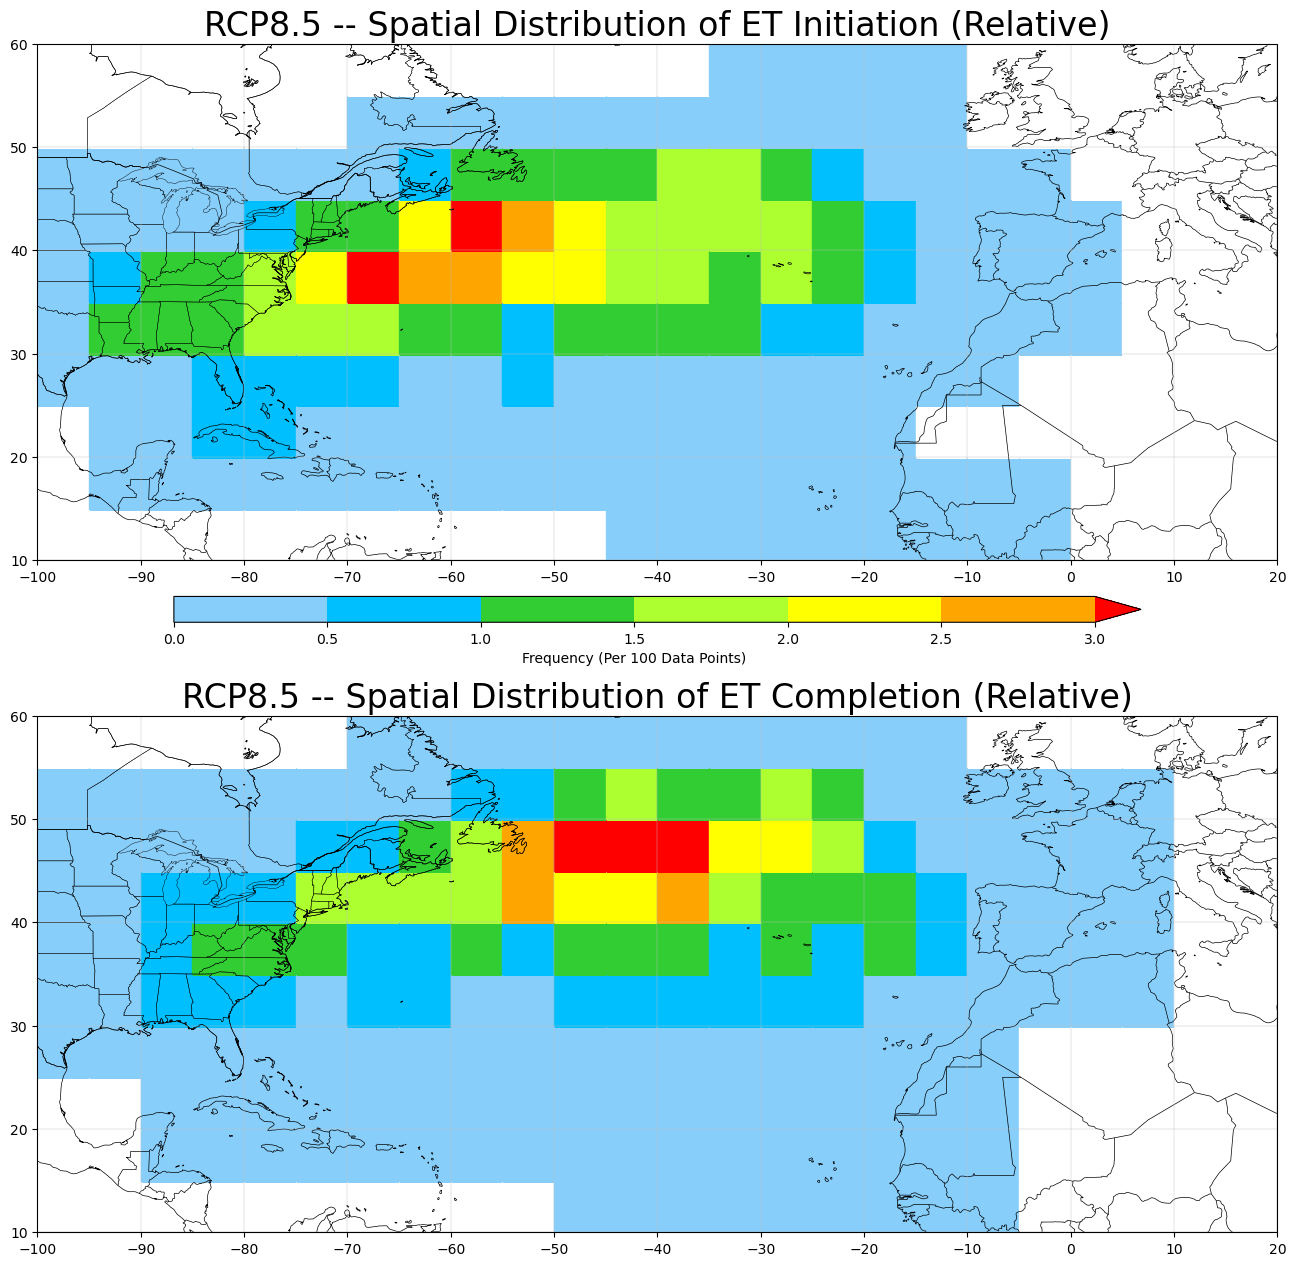

In [74]:
ET_Distr_Plot(RCP85_ET, "RCP8.5", True, True, True)

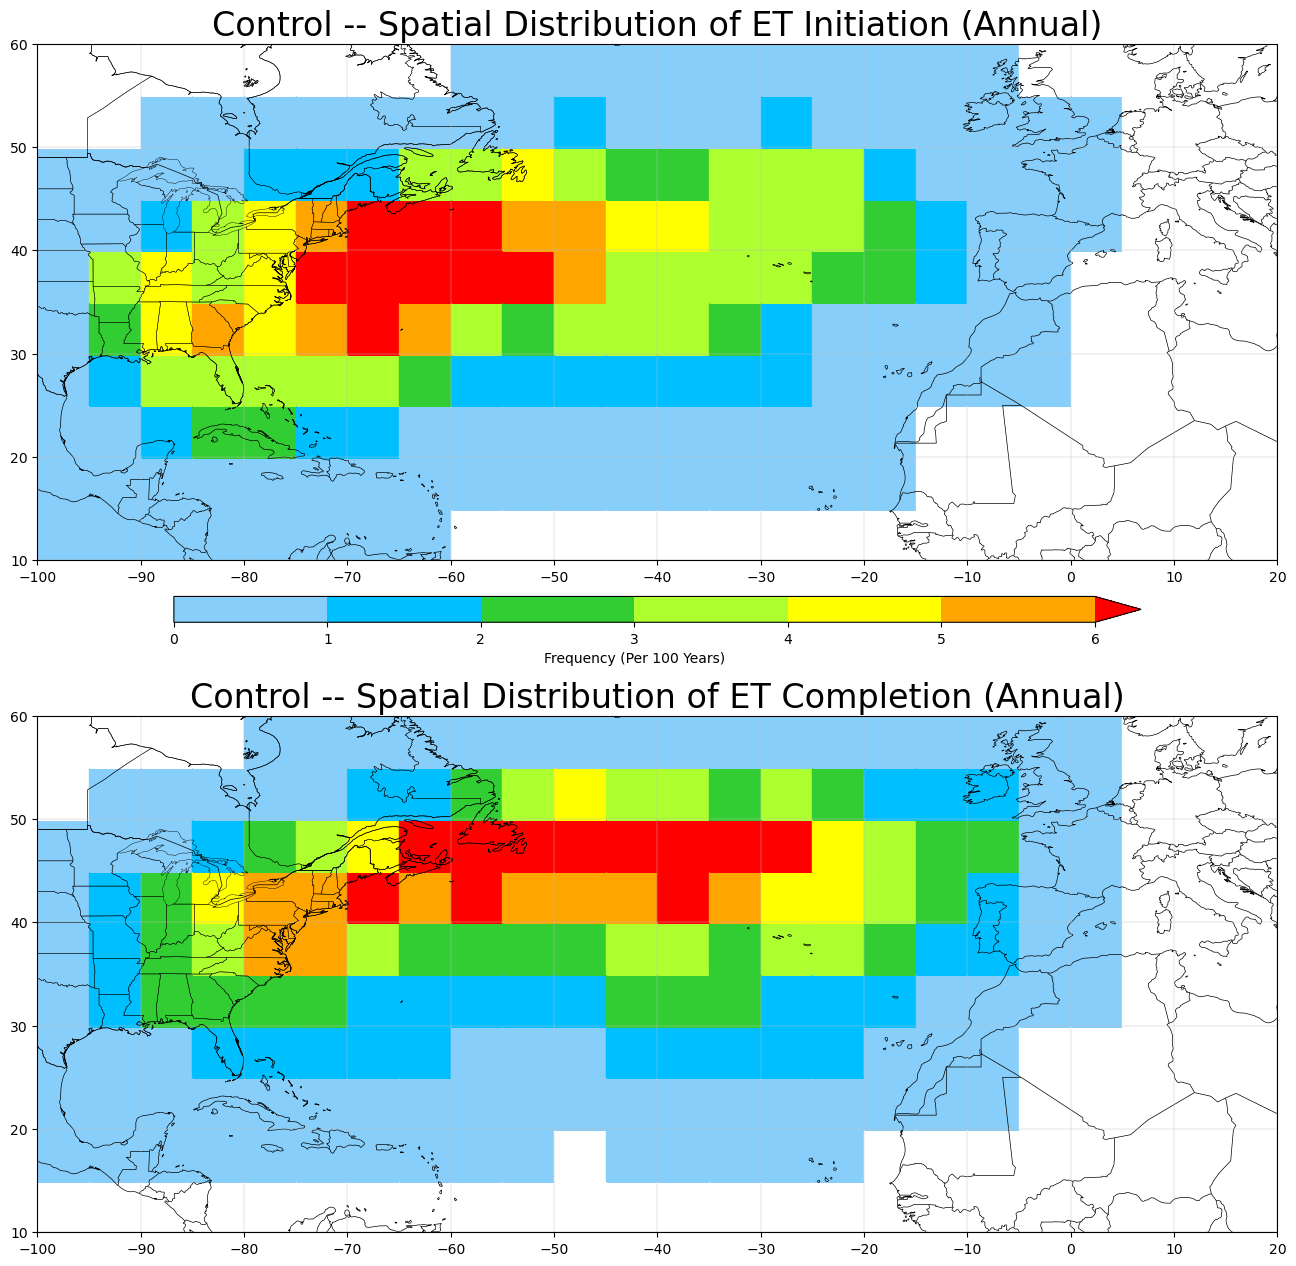

In [75]:
ET_Distr_Plot(Control_ET, "Control", False, True, True)

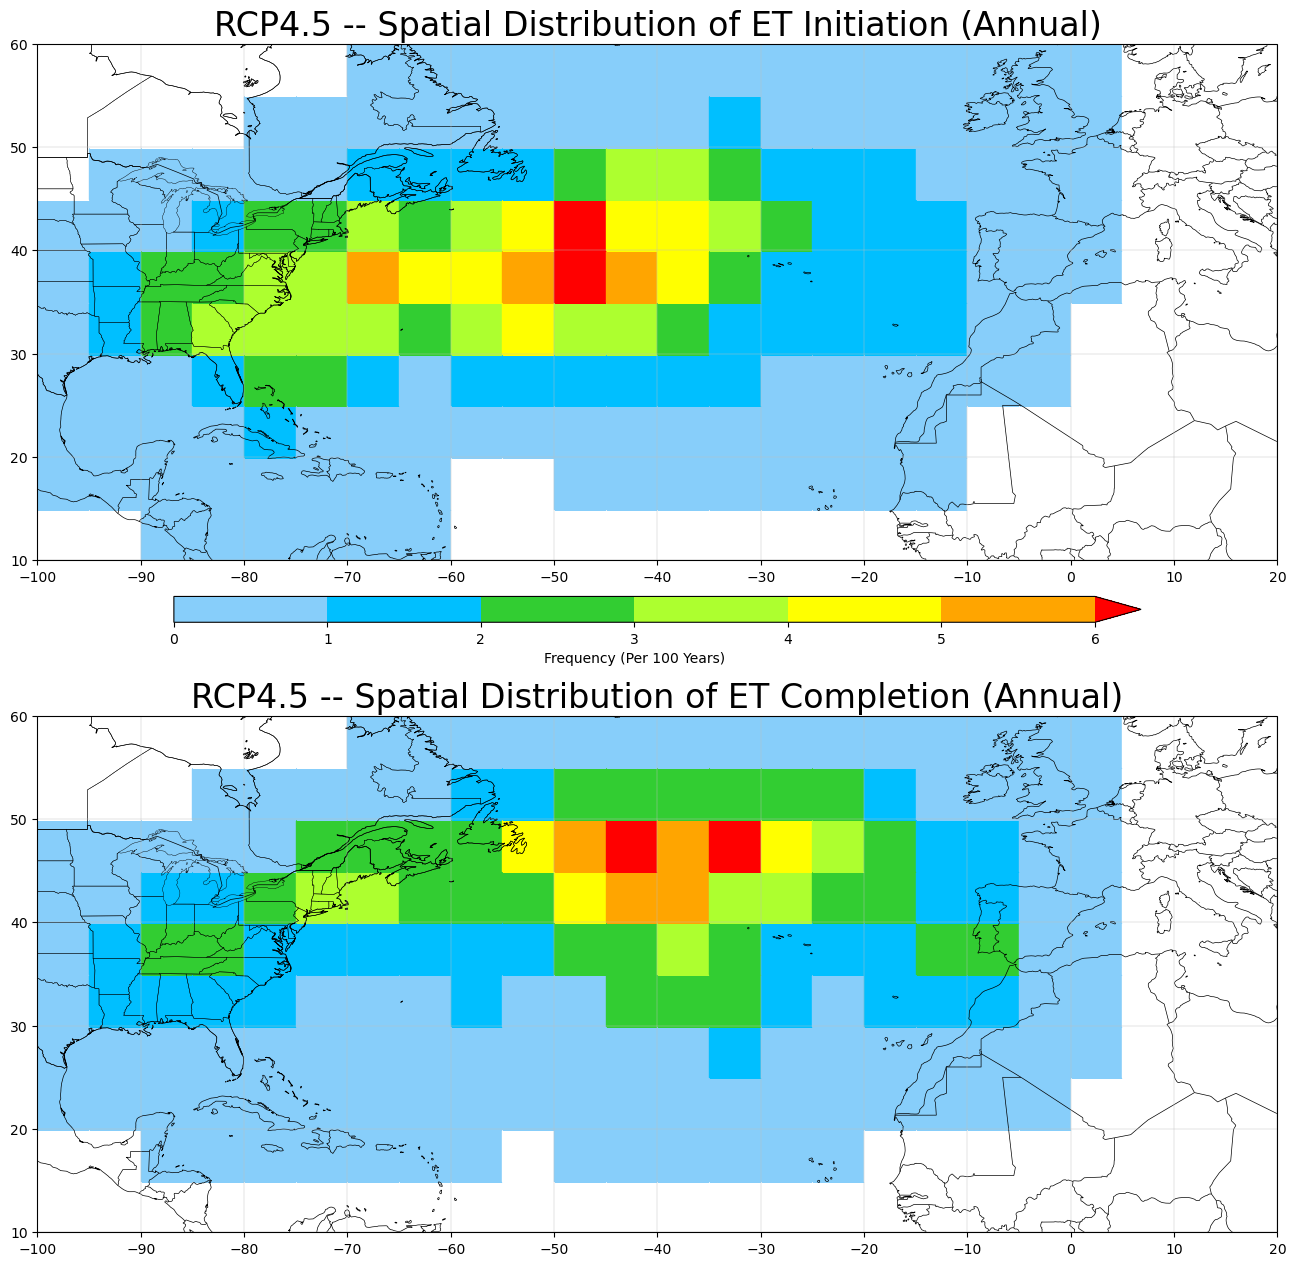

In [76]:
ET_Distr_Plot(RCP45_ET, "RCP4.5", False, True, True)

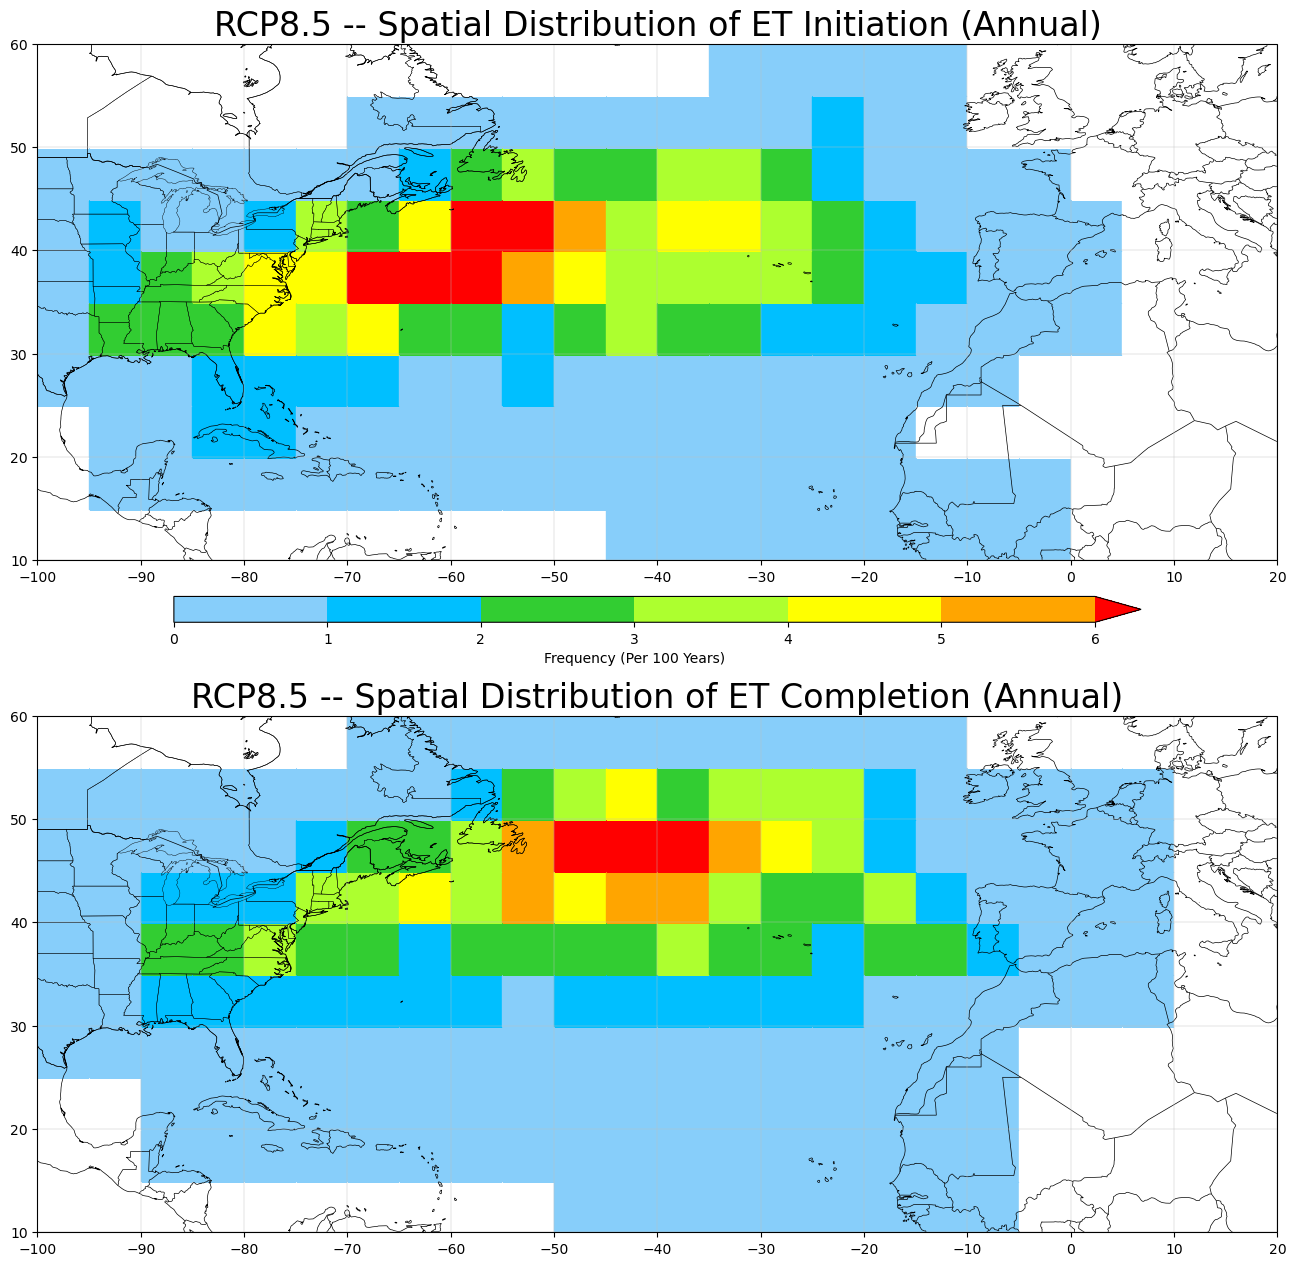

In [77]:
ET_Distr_Plot(RCP85_ET, "RCP8.5", False, True, True)

In [78]:
# Calculate Difference Between Models
def ET_Locs_Diff(ET_DF_1, ET_DF_2, Model_1, Model_2, Rela, Smooth):
    if Smooth == False:
        Begin_1, Compl_1 = ET_Locs_Distr(ET_DF_1, Lat_Bins, Lon_Bins, Model_1, Rela)
        Begin_2, Compl_2 = ET_Locs_Distr(ET_DF_2, Lat_Bins, Lon_Bins, Model_2, Rela)
    else:
        Begin_1, Compl_1 = ET_Locs_Distr_Smooth(ET_DF_1, Lat_Bins, Lon_Bins, Model_1, Rela)
        Begin_2, Compl_2 = ET_Locs_Distr_Smooth(ET_DF_2, Lat_Bins, Lon_Bins, Model_2, Rela)
    Begin_Diff = Begin_1 - Begin_2
    Compl_Diff = Compl_1 - Compl_2
    return (Begin_Diff, Compl_Diff)

In [79]:
# Create Function of Colours of ET Locations Difference Plots
Diff_Colours = ['mediumblue', 'deepskyblue', 'cyan', 'lawngreen', \
'gold', 'darkorange', 'red']
Rela_Diff_Bounds = numpy.array([-1.5,-1,-0.5,0.5,1,1.5])
Annual_Diff_Bounds = numpy.array([-3,-2,-1,1,2,3])
#
def Spatial_Diff_Colour(Diff, Bounds, Colours):
    for k in range(len(Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff <= Bounds[k]:
                    Colour = Colours[k]
            elif k < len(Colours)-1:
                if Diff <= Bounds[k] and Diff > Bounds[k-1]:
                    Colour = Colours[k]
            else:
                if Diff > Bounds[k-1]:
                    Colour = Colours[k]
    return (Colour)

In [80]:
# Create Function to Plot ET Begin and Complete Locations
def ET_Diff_Plot(Model_1, Model_2, ET_DF_1, ET_DF_2, Rela, Smooth, Savefig):
    Begin_Diff, Compl_Diff = ET_Locs_Diff(ET_DF_1, ET_DF_2, Model_1, Model_2, Rela, Smooth)
#
# Define Colours and Bounds
    if Rela == True:
        Bounds = Rela_Diff_Bounds
    else:
        Bounds = Annual_Diff_Bounds
    Colours = Diff_Colours
    Fig = pyplot.figure(figsize=(16,16))
#
# Plot ET Begin Data
    Axis = Fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
    for j in range(len(Begin_Diff)):
        for k in range(len(Begin_Diff[0])):
            Colour = Spatial_Diff_Colour(Begin_Diff[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    if Rela == True:
        Type = "Relative"
    else:
        Type = "Annual"
    Title = Model_1 + " - " + Model_2 + " -- Spatial Distribution of ET Initiation (" + Type + ")"
    Axis.set_title(Title, fontsize=24)
#
# Colour Bar
    if Rela == True:
        Cbar_Label = 'Frequency Difference (Per 100 Data Points)'
    else:
        Cbar_Label = 'Frequency Difference (Per 100 Years)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Frequency of Locations", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.11, -0.12, 0.78, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, ticks=Bounds, \
    label=Cbar_Label)
#
# Plot ET Complete Data
    Axis = Fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
    for j in range(len(Compl_Diff)):
        for k in range(len(Compl_Diff[0])):
            Colour = Spatial_Diff_Colour(Compl_Diff[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    Title = Model_1 + " - " + Model_2 + " -- Spatial Distribution of ET Completion (" + Type + ")"
    Axis.set_title(Title, fontsize=24)
#
# Save Fig
    if Savefig == True:
        Figname = str(Model_1 + '-' + Model_2 + '_ET_Spatial_Diff.png')
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

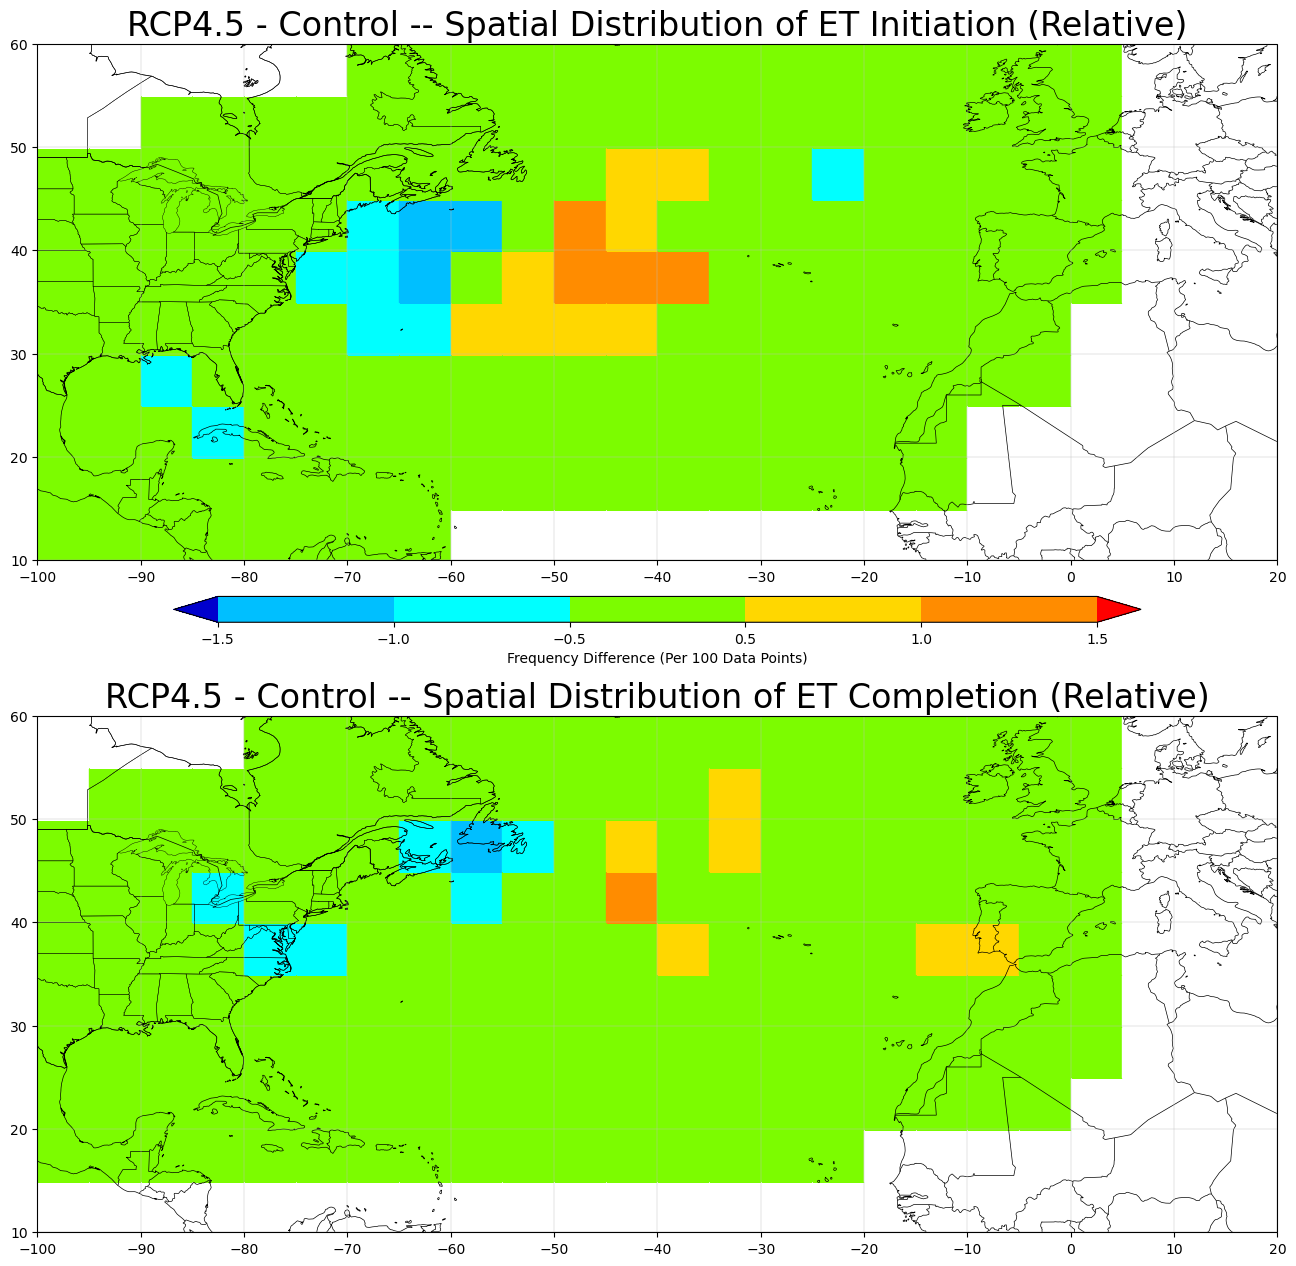

In [81]:
ET_Diff_Plot("RCP4.5", "Control", RCP45_ET, Control_ET, True, True, True)

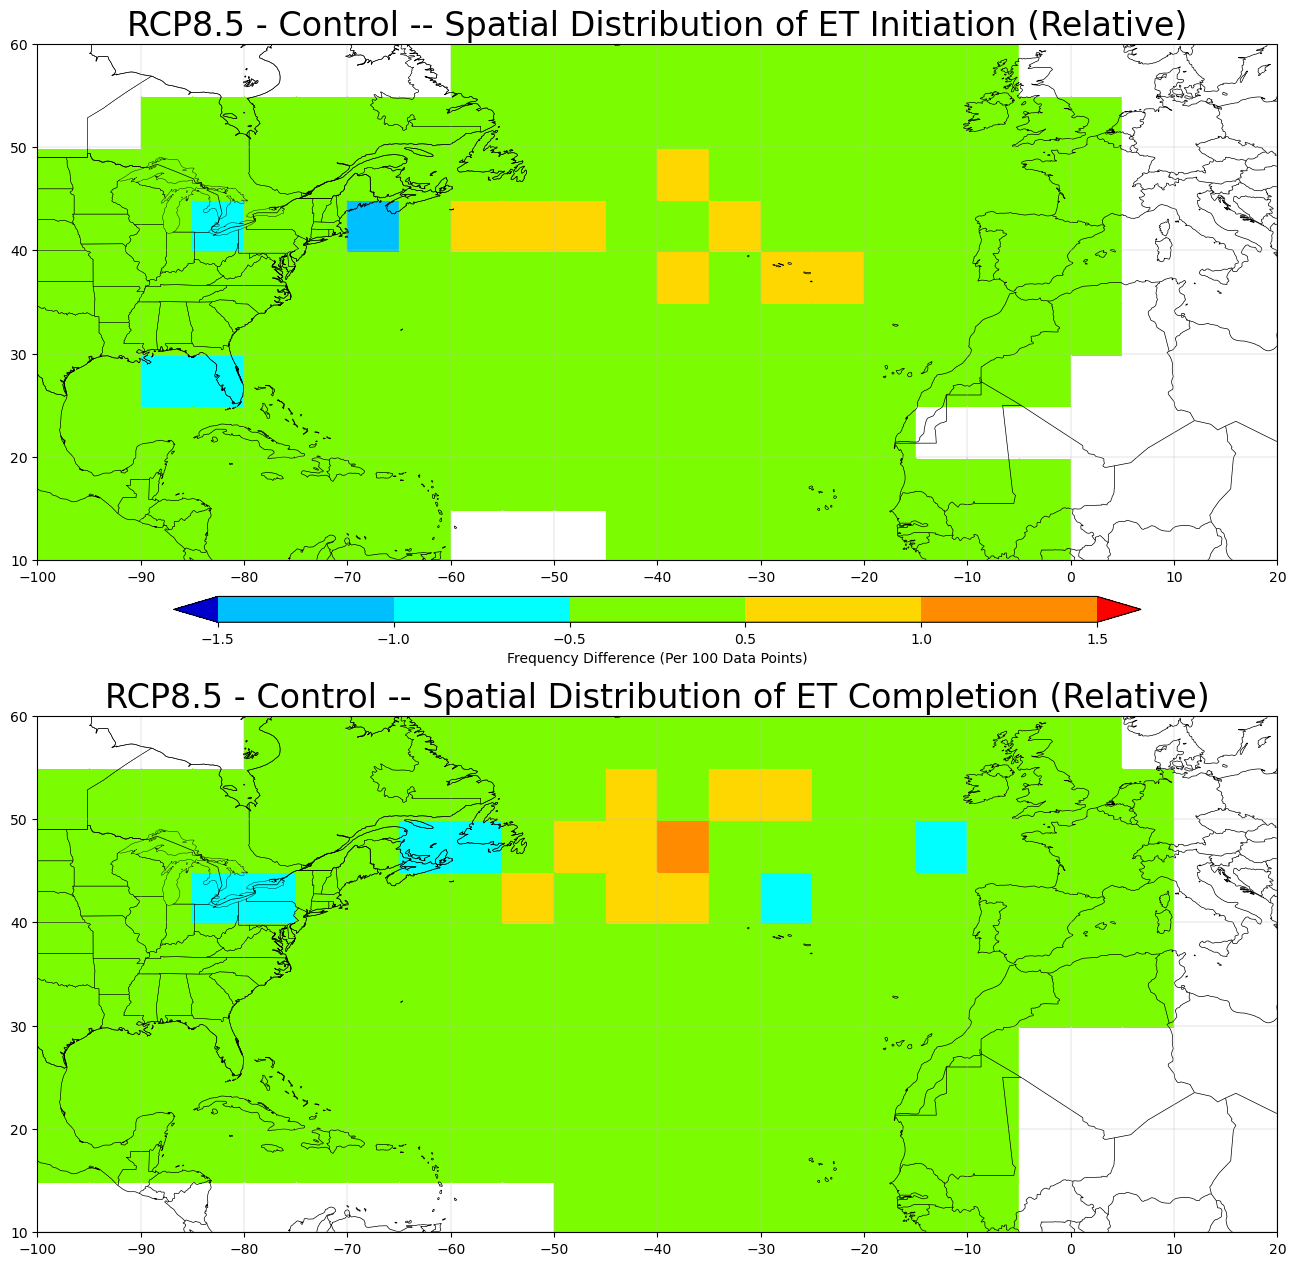

In [82]:
ET_Diff_Plot("RCP8.5", "Control", RCP85_ET, Control_ET, True, True, True)

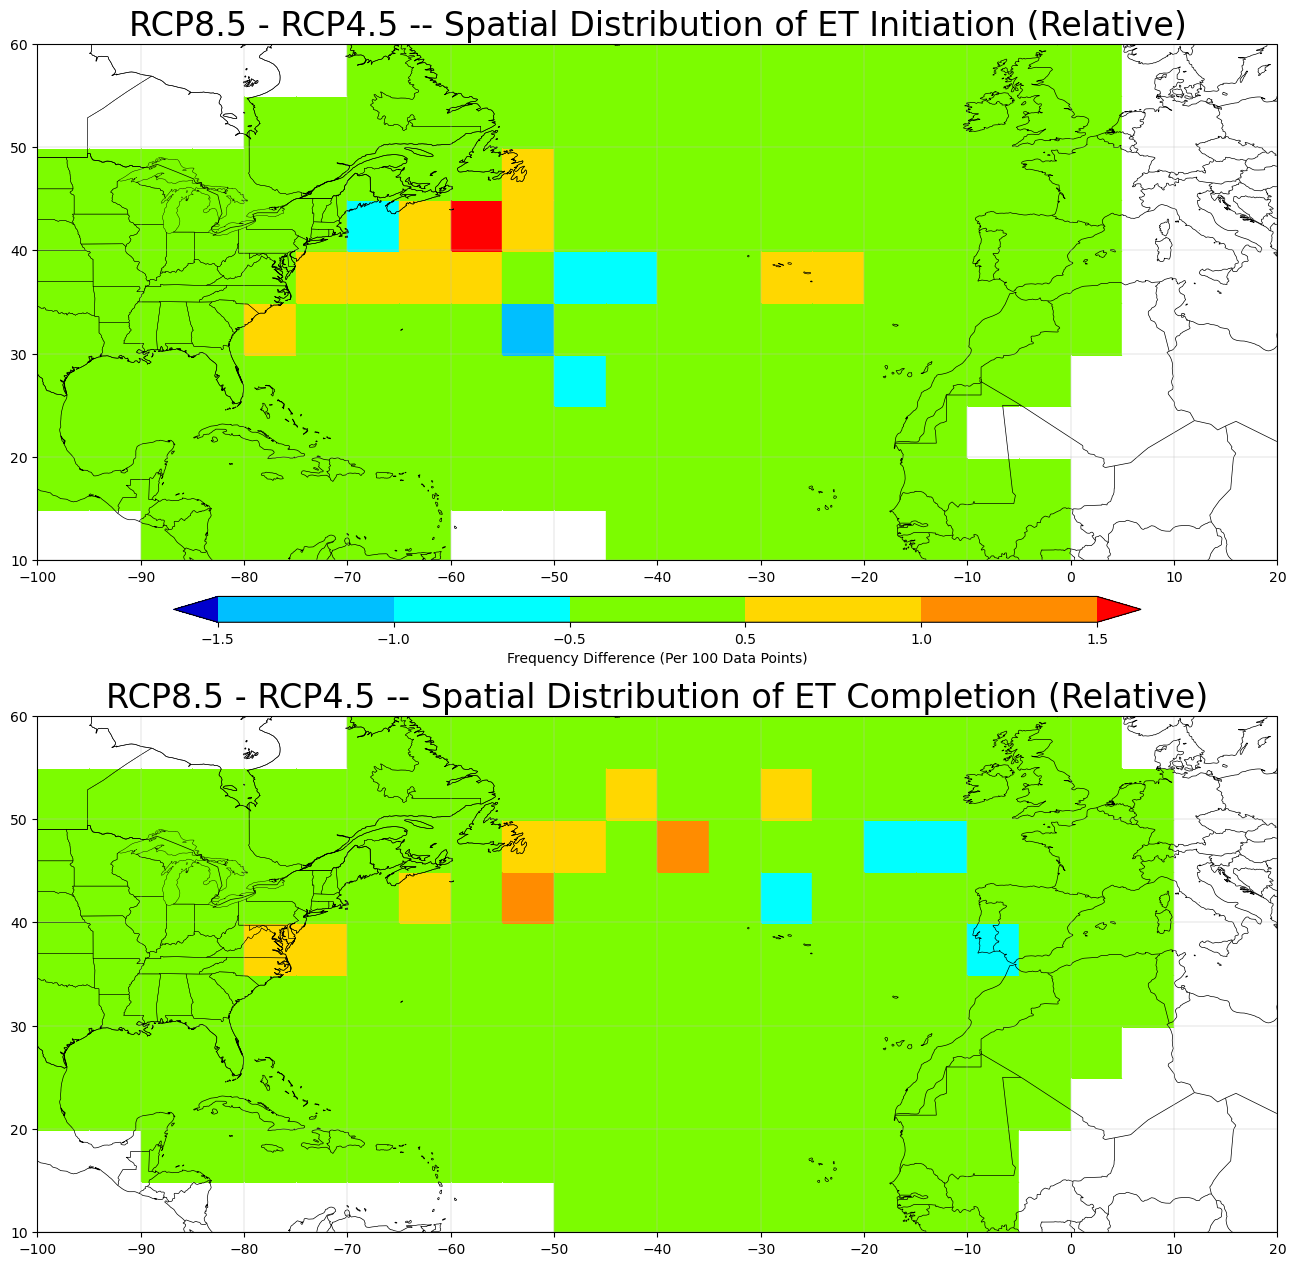

In [83]:
ET_Diff_Plot("RCP8.5", "RCP4.5", RCP85_ET, RCP45_ET, True, True, True)

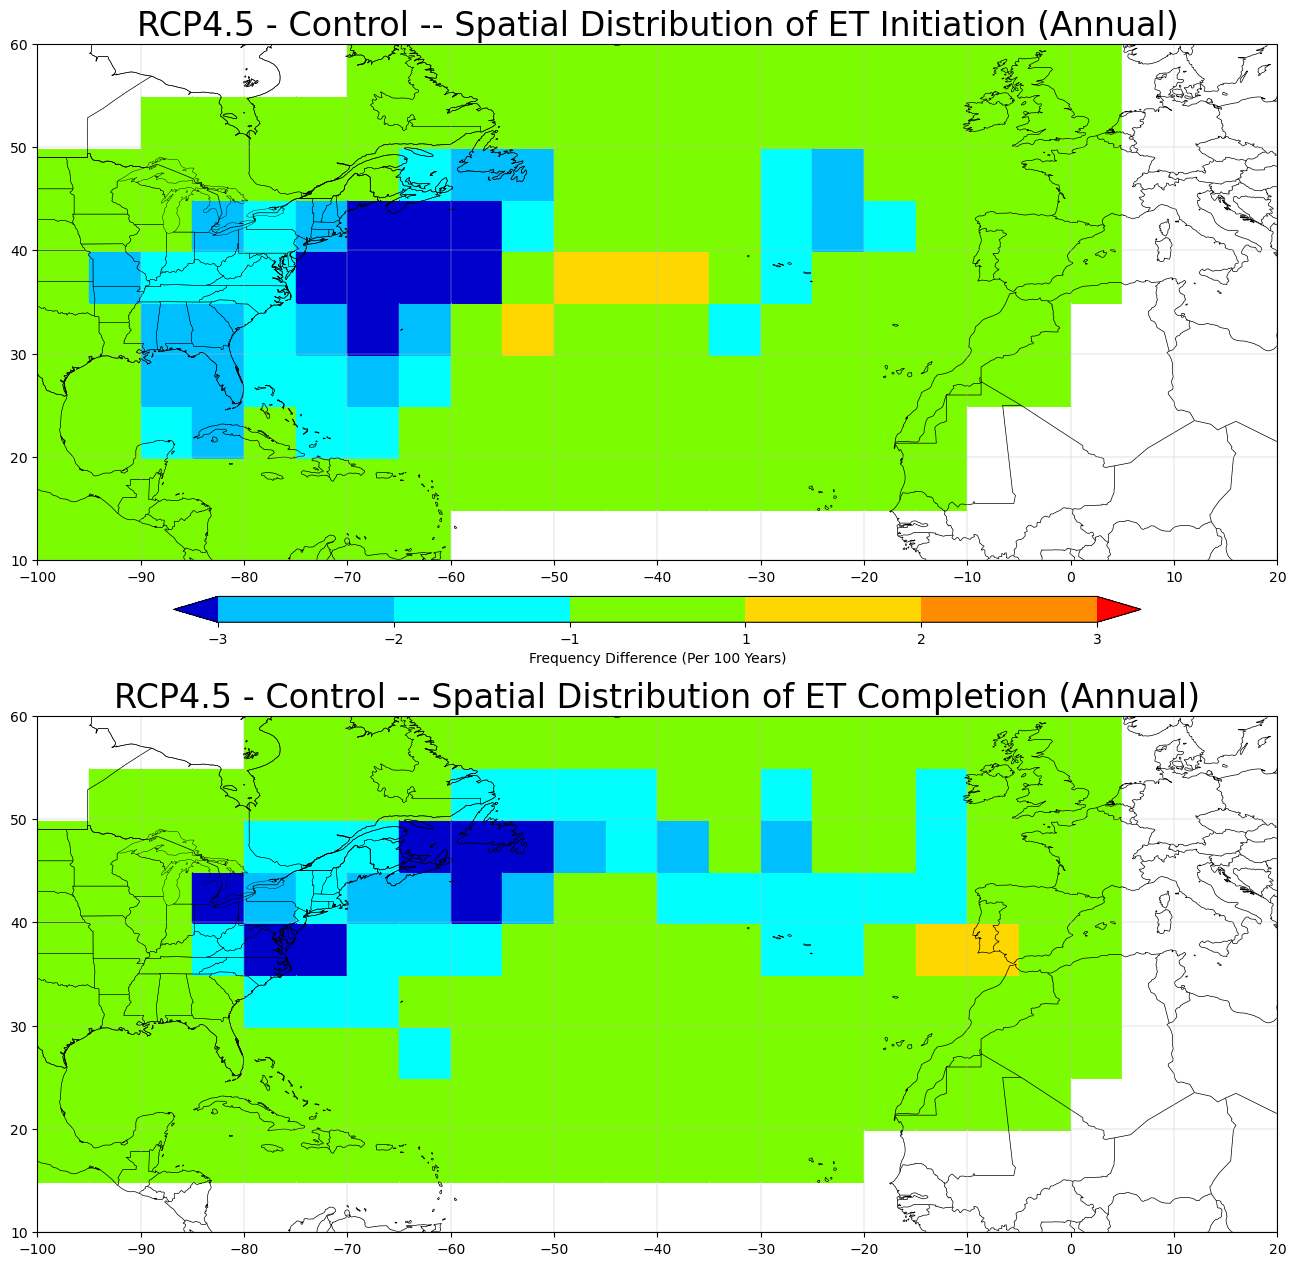

In [84]:
ET_Diff_Plot("RCP4.5", "Control", RCP45_ET, Control_ET, False, True, True)

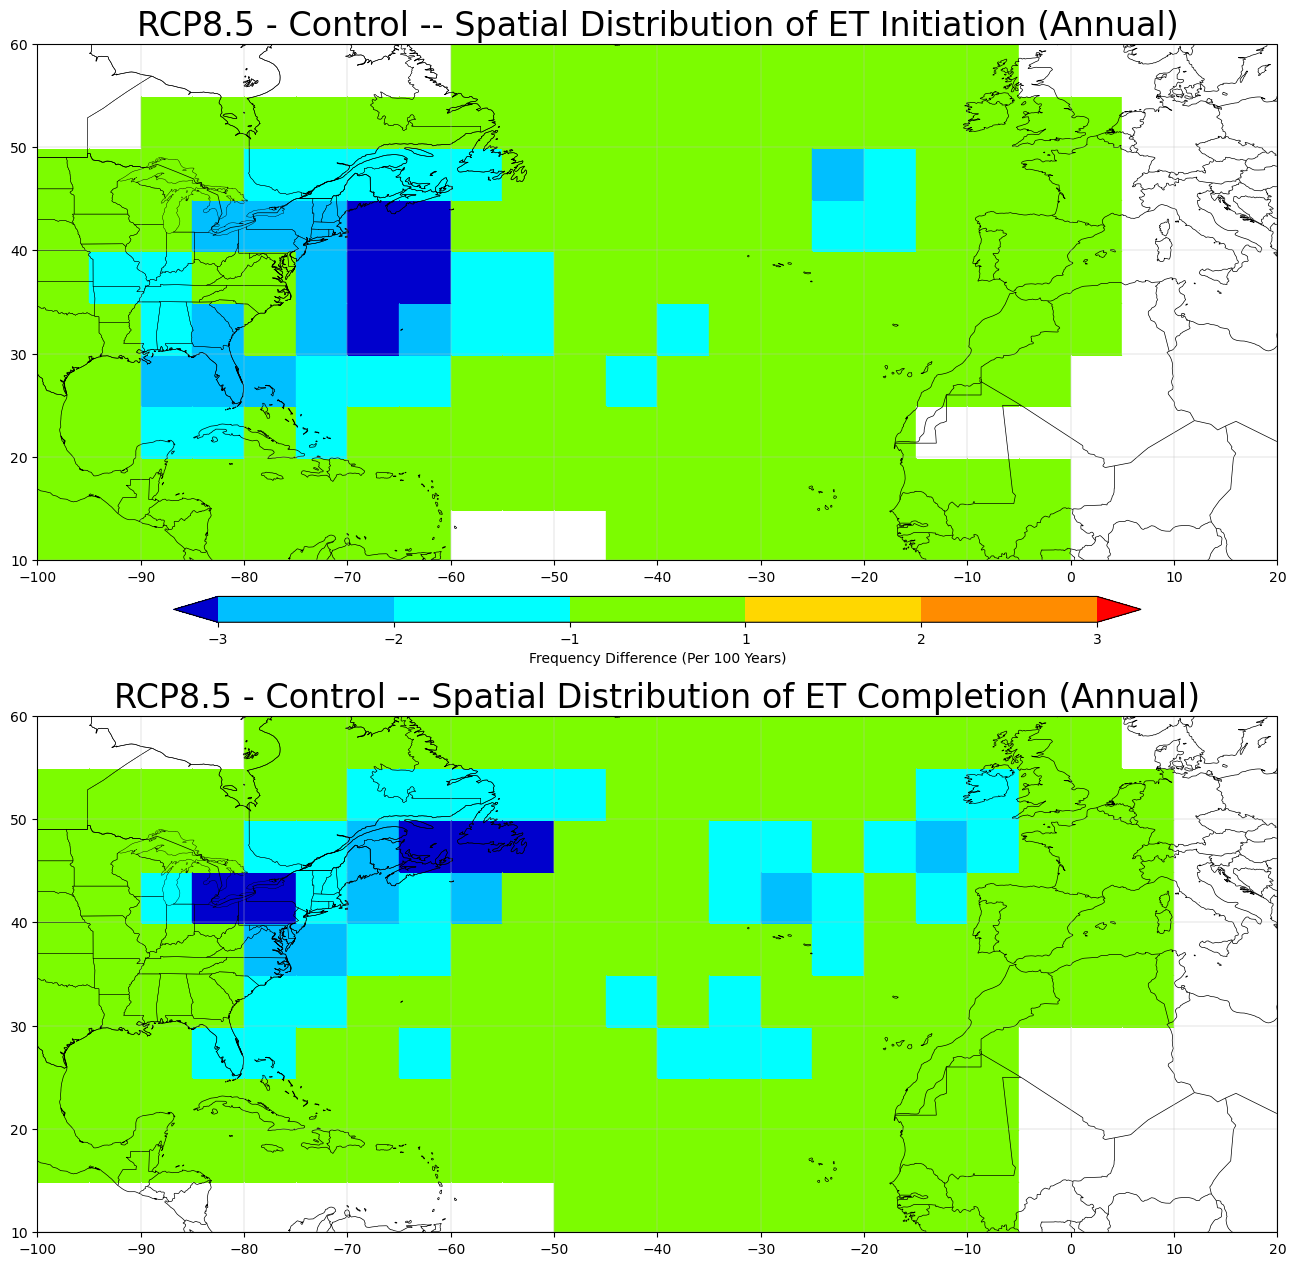

In [85]:
ET_Diff_Plot("RCP8.5", "Control", RCP85_ET, Control_ET, False, True, True)

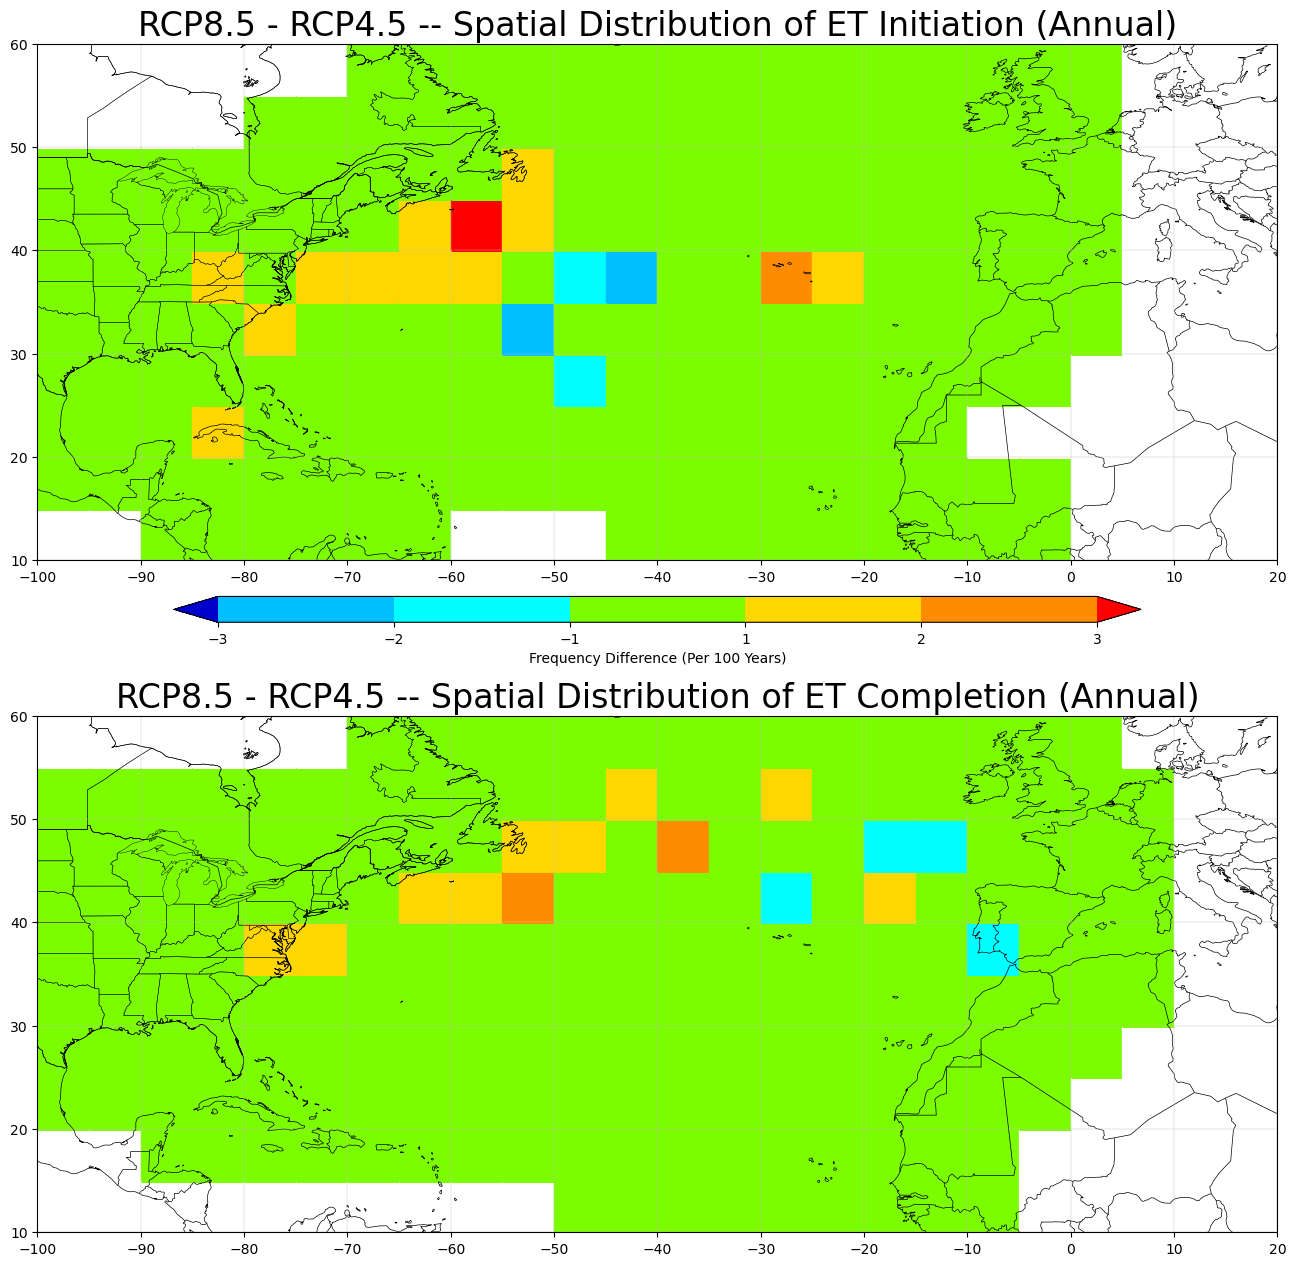

In [86]:
ET_Diff_Plot("RCP8.5", "RCP4.5", RCP85_ET, RCP45_ET, False, True, True)